## クレジットカード不正予測

### ライブラリのインポート

In [371]:
import time # 学習時間計測に利用

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df = pd.read_csv('./data/creditcard.csv')

In [3]:
# データを表示
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [4]:
# データ量確認
df.shape

(284807, 31)

## EDA (Expolatory Data Analysis) 探索的データ解析
### First EDA

- Time: トランザクションからの経過時間
- V1 - V28: 数値データ。元のデータをPCAによって28個のデータに変換
- Amount: 金額
- Class: 不正か正常かを表す目的変数

In [5]:
# カラム確認
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# 基礎統計量の確認
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# データの型や欠損確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# 各列のunique数を確認
for col in df.columns:
    print('{} uniques: '.format(col), len(df[col].value_counts()))

Time uniques:  124592
V1 uniques:  275663
V2 uniques:  275663
V3 uniques:  275663
V4 uniques:  275663
V5 uniques:  275663
V6 uniques:  275663
V7 uniques:  275663
V8 uniques:  275663
V9 uniques:  275663
V10 uniques:  275663
V11 uniques:  275663
V12 uniques:  275663
V13 uniques:  275663
V14 uniques:  275663
V15 uniques:  275663
V16 uniques:  275663
V17 uniques:  275663
V18 uniques:  275663
V19 uniques:  275663
V20 uniques:  275663
V21 uniques:  275663
V22 uniques:  275663
V23 uniques:  275663
V24 uniques:  275663
V25 uniques:  275663
V26 uniques:  275663
V27 uniques:  275663
V28 uniques:  275663
Amount uniques:  32767
Class uniques:  2


In [12]:
# データについてmin max の確認
for col in df.columns:
    print('{} max: '.format(col), df[col].max(), '{} min: '.format(col), df[col].min())

Time max:  172792.0 Time min:  0.0
V1 max:  2.45492999121121 V1 min:  -56.407509631329
V2 max:  22.0577289904909 V2 min:  -72.7157275629303
V3 max:  9.38255843282114 V3 min:  -48.3255893623954
V4 max:  16.8753440335975 V4 min:  -5.68317119816995
V5 max:  34.8016658766686 V5 min:  -113.74330671114599
V6 max:  73.3016255459646 V6 min:  -26.1605059358433
V7 max:  120.589493945238 V7 min:  -43.5572415712451
V8 max:  20.0072083651213 V8 min:  -73.21671845526741
V9 max:  15.5949946071278 V9 min:  -13.4340663182301
V10 max:  23.7451361206545 V10 min:  -24.5882624372475
V11 max:  12.018913181619899 V11 min:  -4.79747346479757
V12 max:  7.8483920756445995 V12 min:  -18.683714633344298
V13 max:  7.126882958593759 V13 min:  -5.7918812063208405
V14 max:  10.5267660517847 V14 min:  -19.2143254902614
V15 max:  8.87774159774277 V15 min:  -4.49894467676621
V16 max:  17.315111517627802 V16 min:  -14.1298545174931
V17 max:  9.25352625047285 V17 min:  -25.162799369324798
V18 max:  5.04106918541184 V18 mi

In [13]:
df.iloc[:, 0].dtypes == np.float64

True

In [14]:
# min, maxの値が非常に大きいわけではないので、float64 → float32に変換
for col in df.columns:
    if df[col].dtypes == np.float64:
        df[col] = df[col].astype(np.float32)

In [15]:
# 変換後データについてmin max の確認
# 小数点以下切り捨てになってるけど大きく影響はないと思われ。
for col in df.columns:
    print('{} max: '.format(col), df[col].max(), '{} min: '.format(col), df[col].min())

Time max:  172792.0 Time min:  0.0
V1 max:  2.454930067062378 V1 min:  -56.407508850097656
V2 max:  22.057729721069336 V2 min:  -72.71572875976562
V3 max:  9.382558822631836 V3 min:  -48.32558822631836
V4 max:  16.875343322753906 V4 min:  -5.683171272277832
V5 max:  34.801666259765625 V5 min:  -113.7433090209961
V6 max:  73.30162811279297 V6 min:  -26.160505294799805
V7 max:  120.58949279785156 V7 min:  -43.55724334716797
V8 max:  20.0072078704834 V8 min:  -73.21672058105469
V9 max:  15.59499454498291 V9 min:  -13.434066772460938
V10 max:  23.745136260986328 V10 min:  -24.5882625579834
V11 max:  12.018913269042969 V11 min:  -4.797473430633545
V12 max:  7.848392009735107 V12 min:  -18.683713912963867
V13 max:  7.126883029937744 V13 min:  -5.791881084442139
V14 max:  10.526765823364258 V14 min:  -19.214324951171875
V15 max:  8.877741813659668 V15 min:  -4.4989447593688965
V16 max:  17.31511116027832 V16 min:  -14.129854202270508
V17 max:  9.25352668762207 V17 min:  -25.162799835205078
V1

In [16]:
# 影響の少ない範囲での型変換でメモリ使用量が半分に
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [17]:
df['Time'] = df['Time'].astype(np.uint32)
df['Amount'] = df['Amount'].astype(np.float16)
df['Class'] = df['Class'].astype(bool)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  uint32 
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

### カラムに関する基礎調査

In [19]:
# 偏りの発生しているデータ
df['Class'].value_counts()

False    284315
True        492
Name: Class, dtype: int64

In [20]:
# 重複データも少しある
print('True duplicated: ', df[df['Class'] == True].duplicated().sum())
print('False duplicated: ', df[df['Class'] == False].duplicated().sum())

True duplicated:  19
False duplicated:  1062


In [22]:
# 先んじて重複している行を削除する
df = df.drop_duplicates()

In [23]:
# 重複データを削除
print('True duplicated: ', df[df['Class'] == True].duplicated().sum())
print('False duplicated: ', df[df['Class'] == False].duplicated().sum())

True duplicated:  0
False duplicated:  0


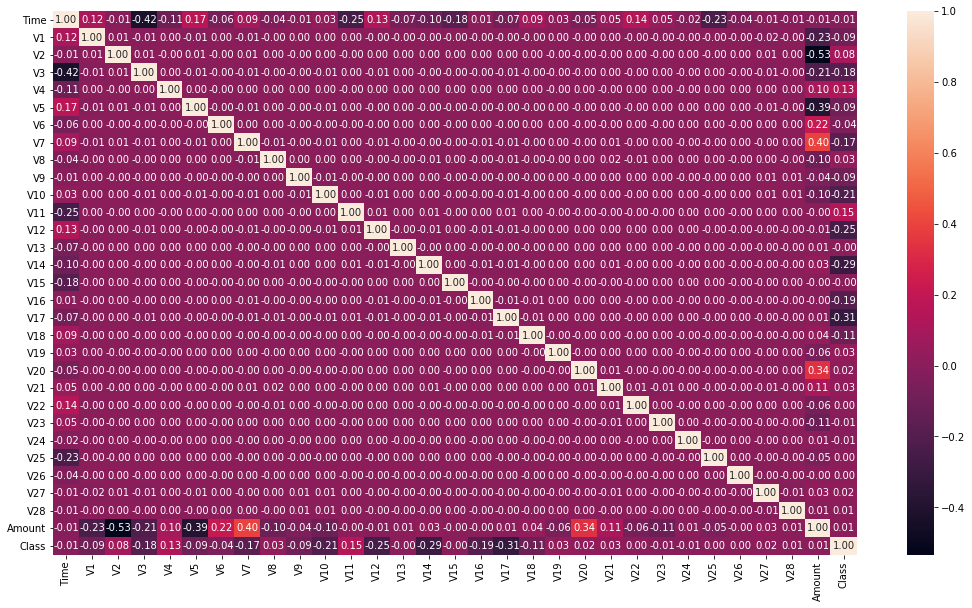

In [25]:
# 各特徴量との相関行列を確認する
# 特に大きな相関は見られない(元データを次元圧縮して変換していることや・データの偏りによるもの？)
import seaborn as sns
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, fmt="0.2f")

In [544]:
df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_round_minus2
Time,1.000000,0.117927,-0.010556,-0.422054,-0.105845,0.173223,-0.063279,0.085335,-0.038203,-0.007861,...,0.143727,0.051474,-0.015954,-0.233262,-0.041818,-0.005171,-0.009305,-0.010558,-0.012359,1.000000
V1,0.117927,1.000000,0.006875,-0.008112,0.002257,-0.007036,0.000413,-0.009173,-0.001168,0.001828,...,-0.001436,-0.001330,-0.000723,-0.000222,-0.000684,-0.015706,-0.004861,-0.230104,-0.094486,0.117925
V2,-0.010556,0.006875,1.000000,0.005278,-0.001495,0.005210,-0.000594,0.007425,0.002899,-0.000274,...,0.001237,-0.003855,0.000701,-0.001569,0.000253,0.007555,0.001611,-0.533425,0.084624,-0.010558
V3,-0.422054,-0.008112,0.005278,1.000000,0.002829,-0.006879,-0.001511,-0.011721,-0.001815,-0.003579,...,-0.000275,0.000449,-0.000072,0.000425,-0.000094,-0.007051,-0.000134,-0.212411,-0.182322,-0.422053
V4,-0.105845,0.002257,-0.001495,0.002829,1.000000,0.001744,-0.000880,0.004657,0.000890,0.002154,...,0.000115,0.000732,-0.000120,0.000162,0.000777,0.001322,0.000231,0.099514,0.129326,-0.105846
V5,0.173223,-0.007036,0.005210,-0.006879,0.001744,1.000000,-0.000938,-0.008709,0.001430,-0.001213,...,-0.000559,0.001183,0.000198,0.000069,0.000390,-0.005798,-0.000820,-0.387684,-0.087812,0.173221
V6,-0.063279,0.000413,-0.000594,-0.001511,-0.000880,-0.000938,1.000000,0.000436,0.003036,-0.000734,...,0.001104,-0.000755,0.001202,0.000697,-0.000028,0.000289,0.000925,0.216387,-0.043915,-0.063276
V7,0.085335,-0.009173,0.007425,-0.011721,0.004657,-0.008709,0.000436,1.000000,-0.006419,-0.004921,...,-0.002280,0.003303,-0.000384,-0.000072,0.000624,-0.004537,0.001657,0.400409,-0.172347,0.085334
V8,-0.038203,-0.001168,0.002899,-0.001815,0.000890,0.001430,0.003036,-0.006419,1.000000,0.001038,...,-0.006156,0.004994,0.000113,0.000011,-0.001407,0.000613,-0.000099,-0.104661,0.033068,-0.038201
V9,-0.007861,0.001828,-0.000274,-0.003579,0.002154,-0.001213,-0.000734,-0.004921,0.001038,1.000000,...,0.000785,0.000677,-0.000103,-0.000275,0.001253,0.008221,0.005591,-0.044122,-0.094021,-0.007864


## 学習(サイクル1)
- ひとまずそのまま学習モデルを作成して、特徴量重要度を確認する
- ベースモデルを元に、これより精度を向上させる

In [33]:
# 学習結果を確認するための便利な関数を定義
# (講義内で使用した関数を引用)
def get_classification_result(clf, X_train, y_train, X_test, y_test):
    """
    学習結果と予測結果をまとめて返す
    """
    # 学習データ：予測結果
    y_pred = clf.predict(X_train)
    train_classification_report = classification_report(y_train, y_pred)
    # 学習データ：混同行列
    train_confusion_matrix = confusion_matrix(y_train, y_pred)

    # テストデータ：予測結果
    y_pred_test = clf.predict(X_test)
    test_classification_report = classification_report(y_test, y_pred_test)
    # テストデータ：混同行列
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    return train_classification_report, train_confusion_matrix, test_classification_report, test_confusion_matrix

def plot_feature_importance(df, model):
    """
    ツリー系アルゴリズムを利用したときの特徴量の重要度を可視化する
    """
    plt.figure(figsize=(10, 6))
    columns = X_train.columns.tolist()
    fe = model.feature_importances_
    
    series = pd.Series(dict(zip(columns, fe)))
    series.sort_values().plot(kind='barh')
    plt.show()

In [28]:
# 説明変数・目的変数の分割
X = df.drop('Class', axis=1)#.loc[:, df.columns.str.contains('V')]
y = df['Class']

# 学習データ・テストデータへの分割
# 手を加えてない状態のデータ・手を加えた状態のデータ
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.3, random_state=98, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=98, stratify=y)

In [31]:
# あんまり手を加えてない状態で、ランダムフォレストで学習を実行
# 大体3分くらい
clf_base = RandomForestClassifier()
tic = time.time()
clf_base.fit(X_train_b, y_train_b)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 167.45204067230225s


In [76]:
train_cr_base, train_matrix_base, test_cr_base, test_matrix_base = \
    get_classification_result(clf_base, X_train_b, y_train_b, X_test_b, y_test_b)

In [35]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    198277
        True       1.00      1.00      1.00       331

    accuracy                           1.00    198608
   macro avg       1.00      1.00      1.00    198608
weighted avg       1.00      1.00      1.00    198608

学習データ：混同行列
 [[198277      0]
 [     1    330]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.93      0.84      0.88       142

    accuracy                           1.00     85118
   macro avg       0.96      0.92      0.94     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：混同行列
 [[84967     9]
 [   23   119]]


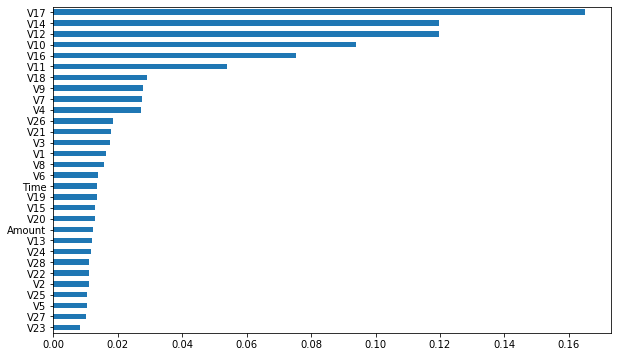

In [36]:
# モデルの特徴量重要度を確認する
plot_feature_importance(X_train_b, clf_base)

- サイクル1でわかったこと
  - ベースモデルでもかなりの分類ができている(不正のうち7.5割ぐらいは解けている)
  - PCAされた特徴のうち2%以上の寄与率を持っている特徴量カラムは以下のようになった
    - V17, V12, V14 (10%以上) 
    - V11, V10, V16(5%以上)
    - V9, V4, V7(2.5%以上)
    - とくにV17, V12については大きく分類結果に寄与しているのでこれらのデータについて更にEDAを深める

## Second EDA
- 目標としてFeatureImportanceで得られた重要な特徴量3つについて詳しく見ていく

In [37]:
# 重要度の高い特徴についてさらにデータを分析してみる
df.loc[:, ['V17', 'V12', 'V14']].head()

,V17,V12,V14
0,0.207971,-0.617801,-0.311169
1,-0.114805,1.065235,-0.143772
2,1.109969,0.066084,-0.165946
3,-0.684093,0.178228,-0.287924
4,-0.237033,0.538196,-1.119670


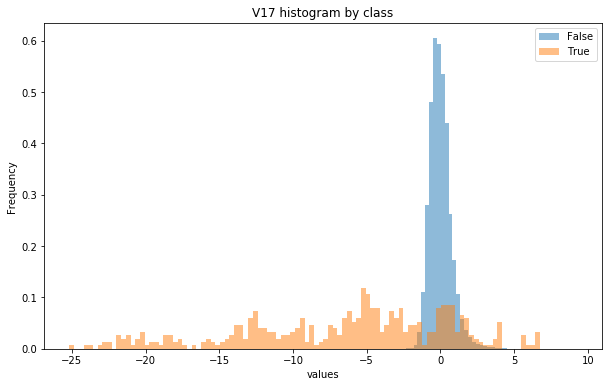

In [40]:
# V17について確認
fig, ax = plt.subplots(figsize=(10, 6))

# density オプションは大きさを正規化したもの (正規化しない場合は正例が多すぎるため、負例の分布が見られなくなってしまう)
df.groupby('Class')['V17'].plot(kind='hist', bins=100, ax=ax, alpha=0.5, density=True)
ax.set_title('V17 histogram by class')
ax.set_xlabel('values')
ax.legend()

In [90]:
# グラフで明確に分けられているデータをみる
df[(df['V17'] < -2) | (df['V17'] > 5)]['Class'].value_counts()

False    360
True     348
Name: Class, dtype: int64

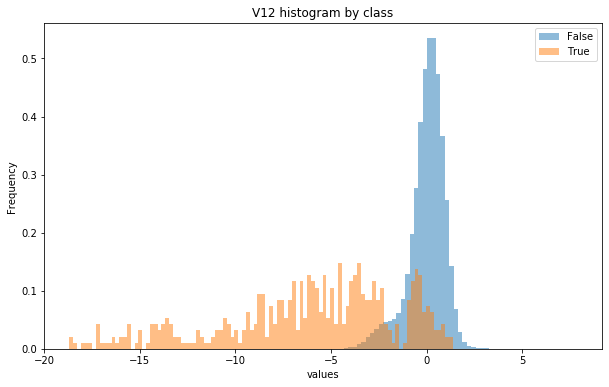

In [41]:
# V12について確認
fig, ax = plt.subplots(figsize=(10, 6))

# density オプションは大きさを正規化したもの
df.groupby('Class')['V12'].plot(kind='hist', bins=100, ax=ax, alpha=0.5, density=True)
ax.set_title('V12 histogram by class')
ax.set_xlabel('values')
ax.legend()

In [100]:
# グラフで明確に分けられているデータをみる
df[(df['V12'] < -5)]['Class'].value_counts()

True     258
False     47
Name: Class, dtype: int64

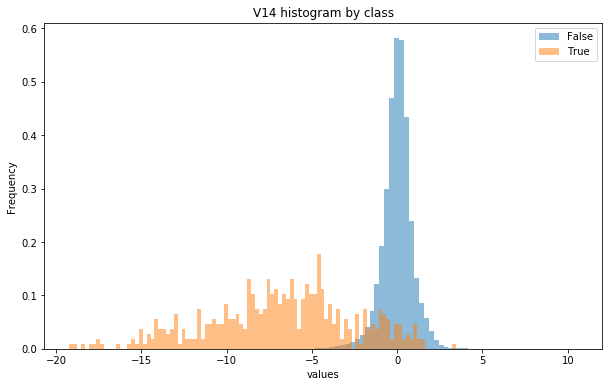

In [42]:
# V14について確認
fig, ax = plt.subplots(figsize=(10, 6))

# density オプションは大きさを正規化したもの
df.groupby('Class')['V14'].plot(kind='hist', bins=100, ax=ax, alpha=0.5, density=True)
ax.set_title('V14 histogram by class')
ax.set_xlabel('values')
ax.legend()

In [93]:
# グラフで明確に分けられているデータをみる
df[(df['V14'] < -5)]['Class'].value_counts()

True     308
False    193
Name: Class, dtype: int64

上記3つの結果を適用したときに当てるのが難しいデータだけで学習させる (2つのグラフが重なっていないところは概ね分けられるため)

In [101]:
# 分けるのが難しいデータを抽出する
indicies = (df['V17'] > -2) | (df['V17'] < 5)
X_train_eda2 = X_train[indicies]
y_train_eda2 = y_train[indicies]

indicies = (df['V12'] > -5)
X_train_eda2 = X_train_eda2[indicies]
y_train_eda2 = y_train_eda2[indicies]

indicies = (df['V14'] > -5)
X_train_eda2 = X_train_eda2[indicies]
y_train_eda2 = y_train_eda2[indicies]

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [102]:
# 学習の元データ
X_train_b.shape

(198608, 30)

In [104]:
# 元データに比べて約400近くはデータが落ちている
X_train_eda2.shape

(198247, 30)

In [105]:
# 学習の元データ
y_train_b.value_counts()

False    198277
True        331
Name: Class, dtype: int64

In [106]:
# 条件を絞るだけでだいたい7割位のデータがしきい値で分けてあげるだけでかなり分けられることがわかる。
y_train_eda2.value_counts()

False    198139
True        108
Name: Class, dtype: int64

このデータで改めてモデルを作ってみて結果を確認する。

## 学習(サイクル2)

In [57]:
# V17, 14, 12 を条件にデータを絞ってランダムフォレストで学習を実行
clf_eda2 = RandomForestClassifier()
tic = time.time()
clf_eda2.fit(X_train_eda2, y_train_eda2)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 145.37816548347473s


In [58]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf_eda2, X_train_eda2, y_train_eda2, X_test, y_test)

In [59]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    198139
        True       1.00      1.00      1.00       108

    accuracy                           1.00    198247
   macro avg       1.00      1.00      1.00    198247
weighted avg       1.00      1.00      1.00    198247

学習データ：混同行列
 [[198139      0]
 [     0    108]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.83      0.75      0.79       142

    accuracy                           1.00     85118
   macro avg       0.92      0.87      0.89     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：混同行列
 [[84955    21]
 [   36   106]]


In [77]:
print('テストデータ：混同行列\n', test_matrix_base)

テストデータ：混同行列
 [[84967     9]
 [   23   119]]


分けやすい特徴をわざと減らしているので学習結果はベースに比べて悪くなっています

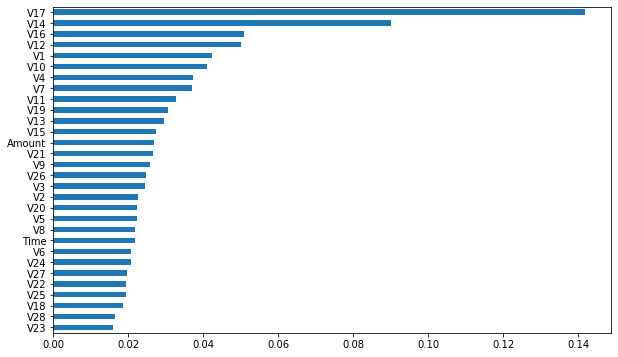

In [78]:
# モデルの特徴量重要度を確認する
plot_feature_importance(X_train_eda2, clf_eda2)

結果として不正データ量を減らしたのでrecallも減る結果となったが、TNをみると、サイクル1のときの結果から不正データを予測しきれていない。これから過学習であることがわかるので不均衡データへのアプローチを行う。

## 学習 (サイクル3)

ここでは研修で習ったオーバーサンプリングとアンダーサンプリングの2通りを簡易的に試して精度が向上したかどうかを確認する。

### ランダムアンダーサンプリングを実施

In [108]:
#Random undersamplingを適用
sampler = RandomUnderSampler(random_state=98)
X_reshaped, y_reshaped = sampler.fit_resample(X_train_eda2, y_train_eda2)

In [109]:
# それぞれのデータ数を確認
print(X_reshaped.shape)
print(y_reshaped.shape)

(216, 30)
(216,)


In [110]:
# 内訳も見てみる → 1:1 のバランスになっている
y_reshaped.value_counts()

True     108
False    108
Name: Class, dtype: int64

In [111]:
# データ数が大きく減っているため、学習が早く終わる
clf = RandomForestClassifier()
clf.fit(X_reshaped, y_reshaped)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf, X_reshaped, y_reshaped, X_test, y_test)

In [113]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       108
        True       1.00      1.00      1.00       108

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

学習データ：混同行列
 [[108   0]
 [  0 108]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      0.88      0.94     84976
        True       0.01      0.95      0.03       142

    accuracy                           0.88     85118
   macro avg       0.51      0.92      0.48     85118
weighted avg       1.00      0.88      0.93     85118

テストデータ：混同行列
 [[74754 10222]
 [    7   135]]


この結果から見ると、いくつかの正常に対して異常を予測しており、むしろ精度が下がってしまっている

### ランダムオーバーサンプリングを実施

In [128]:
# Random over sampling
sampler = RandomOverSampler(random_state=98)
tic = time.time()
X_sampled, y_sampled = sampler.fit_sample(X_train_eda2, y_train_eda2)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 0.2839040756225586s


In [129]:
# それぞれのデータ数を確認
print(X_sampled.shape)
print(y_sampled.shape)

(396278, 30)
(396278,)


In [130]:
# 内訳も見てみる → 1:1 のバランスになっている
y_sampled.value_counts()

True     198139
False    198139
Name: Class, dtype: int64

In [131]:
# 学習データが大きくなっているため時間がかかる
clf_eda2 = RandomForestClassifier()
tic = time.time()
clf_eda2.fit(X_sampled, y_sampled)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 99.84888410568237s


In [134]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf_eda2, X_sampled, y_sampled, X_test, y_test)

In [135]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    198139
        True       1.00      1.00      1.00    198139

    accuracy                           1.00    396278
   macro avg       1.00      1.00      1.00    396278
weighted avg       1.00      1.00      1.00    396278

学習データ：混同行列
 [[198139      0]
 [     0 198139]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.83      0.28      0.42       142

    accuracy                           1.00     85118
   macro avg       0.92      0.64      0.71     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：混同行列
 [[84968     8]
 [  102    40]]


In [137]:
print('テストデータ：混同行列\n', test_matrix_base)

テストデータ：混同行列
 [[84967     9]
 [   23   119]]


ダウンサンプリングよりは幾分かましになった。がベースよりは良くない。

なので

- アンダーサンプリングによるデータバランスを整えるメリット
- オーバーサンプリングによる少量データを増やすメリット

をどちらもうけるために、2つを組み合わせてみる。

### アンダーサンプリングとオーバーサンプリングを組み合わせる

In [141]:
y_train_eda2.sum()

108

In [149]:
# under sampling で 正常:異常 = 5:1 にして
# over sampling で 正常:異常 = 2:1 に整える
under_sample_params = {
    0: y_train_eda2.sum() * 5, # Trueの数を数えて5倍している
    1: y_train_eda2.sum()
}

sampler = RandomUnderSampler(sampling_strategy=under_sample_params, random_state=98)
X_sampled, y_sampled = sampler.fit_resample(X_train_eda2, y_train_eda2)

# それぞれのデータ数を確認
print('Result under sampling')
print(X_sampled.shape)
print(y_sampled.value_counts())

over_sample_params = {
    0: y_sampled.value_counts()[0], # 値はそのまま
    1: y_sampled.value_counts()[0] // 2 # 2:1にするため
}

sampler = RandomOverSampler(sampling_strategy=over_sample_params, random_state=98)
X_sampled, y_sampled = sampler.fit_sample(X_sampled, y_sampled)

# それぞれのデータ数を確認
print('Result over sampling')
print(X_sampled.shape)
print(y_sampled.value_counts())

Result under sampling
(648, 30)
False    540
True     108
Name: Class, dtype: int64
Result over sampling
(810, 30)
False    540
True     270
Name: Class, dtype: int64


In [150]:
# 学習
clf_eda2 = RandomForestClassifier()
tic = time.time()
clf_eda2.fit(X_sampled, y_sampled)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 0.32265782356262207s


In [153]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf_eda2, X_sampled, y_sampled, X_test, y_test)

In [154]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       540
        True       1.00      1.00      1.00       270

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810

学習データ：混同行列
 [[540   0]
 [  0 270]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      0.97      0.99     84976
        True       0.06      0.93      0.11       142

    accuracy                           0.97     85118
   macro avg       0.53      0.95      0.55     85118
weighted avg       1.00      0.97      0.99     85118

テストデータ：混同行列
 [[82832  2144]
 [   10   132]]


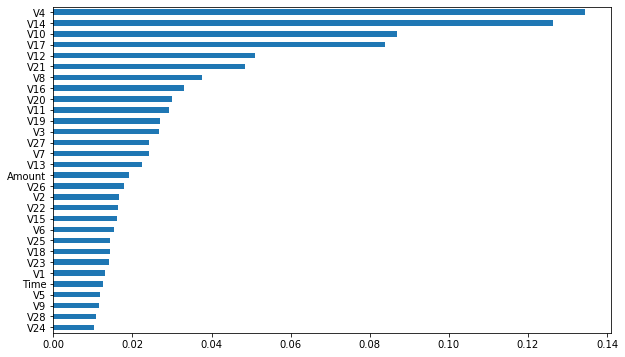

In [156]:
# モデルの特徴量重要度を確認する
plot_feature_importance(X_sampled, clf_eda2)

V17, V14, V12を絞った上でバランスを整えて学習させ、feature_importanceを見るとV14, 10, 4あたりももう少しEDAすることで、より良いモデルを作ることができそう。

### Third EDA

Text(0.5, 0, 'values')

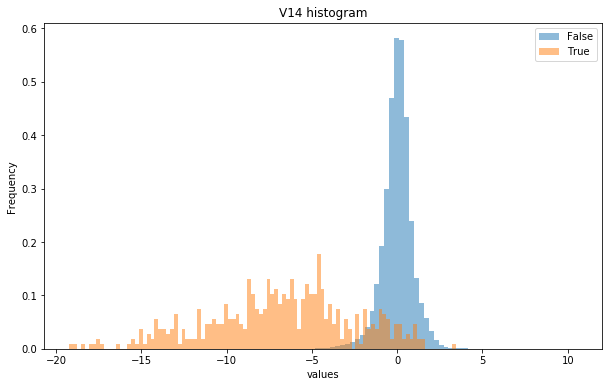

In [158]:
# V14について確認(Second EDAで確認済)
fig, ax = plt.subplots(figsize=(10, 6))

# density オプションは大きさを正規化したもの
df.groupby('Class')['V14'].plot(kind='hist', bins=100, ax=ax, alpha=0.5, density=True)
ax.legend()
ax.set_title('V14 histogram')
ax.set_xlabel('values')

In [162]:
# 絞るしきい値をざっくり調べる
# (-4で絞るのがベストなしきい値っぽい)
for value in [-2, -3, -4, -5]:
    print('value: ', value)
    print(df[(df['V14'] < value)]['Class'].value_counts())

value:  -2
False    6501
True      402
Name: Class, dtype: int64
value:  -3
False    1947
True      386
Name: Class, dtype: int64
value:  -4
False    452
True     361
Name: Class, dtype: int64
value:  -5
True     308
False    193
Name: Class, dtype: int64


Text(0.5, 0, 'values')

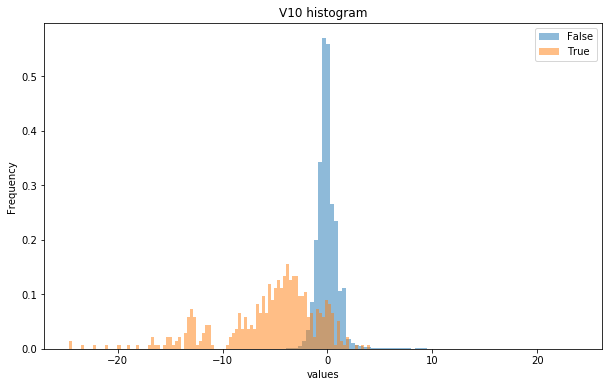

In [163]:
# V10について確認
fig, ax = plt.subplots(figsize=(10, 6))

# density オプションは大きさを正規化したもの
df.groupby('Class')['V10'].plot(kind='hist', bins=100, ax=ax, alpha=0.5, density=True)
ax.legend()
ax.set_title('V10 histogram')
ax.set_xlabel('values')

In [188]:
# V10 についてはだいたい-3くらいをしきい値にするのが良さそう。
for value in [-1, -2, -3, -4, -5]:
    print('value: ', value)
    print(df[(df['V10'] < value)]['Class'].value_counts())

value:  -1
False    30156
True       400
Name: Class, dtype: int64
value:  -2
False    3108
True      376
Name: Class, dtype: int64
value:  -3
False    445
True     326
Name: Class, dtype: int64
value:  -4
True     260
False    175
Name: Class, dtype: int64
value:  -5
True     204
False     93
Name: Class, dtype: int64


Text(0.5, 0, 'values')

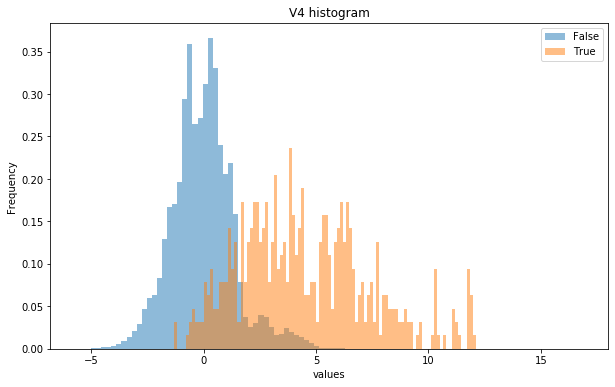

In [167]:
# V４について確認
fig, ax = plt.subplots(figsize=(10, 6))

# density オプションは大きさを正規化したもの
df.groupby('Class')['V4'].plot(kind='hist', bins=100, ax=ax, alpha=0.5, density=True)
ax.legend()
ax.set_title('V4 histogram')
ax.set_xlabel('values')

In [187]:
df['Class'].value_counts()

False    283253
True        473
Name: Class, dtype: int64

In [186]:
# V4 についてはだいたい4くらいをしきい値にするのが良さそう。
for value in [2, 3, 4, 5, 6, 7]:
    print('value: ', value)
    print(df[(df['V4'] > value)]['Class'].value_counts())

value:  2
False    18639
True       377
Name: Class, dtype: int64
value:  3
False    9331
True      309
Name: Class, dtype: int64
value:  4
False    3700
True      243
Name: Class, dtype: int64
value:  5
False    536
True     192
Name: Class, dtype: int64
value:  6
False    193
True     142
Name: Class, dtype: int64
value:  7
False    98
True     84
Name: Class, dtype: int64


In [189]:
# 上記3つの条件に更に絞り込む
indicies = X_train_eda2['V14'] > -3
X_train_eda3 = X_train_eda2[indicies]
y_train_eda3 = y_train_eda2[indicies]

indicies = X_train_eda3['V10'] > -2
X_train_eda3 = X_train_eda3[indicies]
y_train_eda3 = y_train_eda3[indicies]

indicies = X_train_eda3['V4'] < 4
X_train_eda3 = X_train_eda3[indicies]
y_train_eda3 = y_train_eda3[indicies]

In [190]:
y_train_eda2.value_counts()

False    198139
True        108
Name: Class, dtype: int64

In [193]:
# かなりデータが絞れている(正常6000減少・異常50減少)
y_train_eda3.value_counts()

False    192378
True         49
Name: Class, dtype: int64

更に絞り込むことができたので、前回同様にunder, overのサンプリングを組み合わせる。

## 学習(サイクル4)

In [194]:
# under sampling で 正常:異常 = 5:1 にして
# over sampling で 正常:異常 = 2:1 に整える
under_sample_params = {
    0: y_train_eda3.sum() * 5, # Trueの数を数えて5倍している
    1: y_train_eda3.sum()
}

sampler = RandomUnderSampler(sampling_strategy=under_sample_params, random_state=98)
X_sampled, y_sampled = sampler.fit_resample(X_train_eda3, y_train_eda3)

# それぞれのデータ数を確認
print('Result under sampling')
print(X_sampled.shape)
print(y_sampled.value_counts())

over_sample_params = {
    0: y_sampled.value_counts()[0], # 値はそのまま
    1: y_sampled.value_counts()[0] // 2 # 2:1にするため
}

sampler = RandomOverSampler(sampling_strategy=over_sample_params, random_state=98)
X_sampled, y_sampled = sampler.fit_sample(X_sampled, y_sampled)

# それぞれのデータ数を確認
print('Result over sampling')
print(X_sampled.shape)
print(y_sampled.value_counts())

Result under sampling
(294, 30)
False    245
True      49
Name: Class, dtype: int64
Result over sampling
(367, 30)
False    245
True     122
Name: Class, dtype: int64


In [195]:
# 学習
clf_eda3 = RandomForestClassifier()
tic = time.time()
clf_eda3.fit(X_sampled, y_sampled)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 0.20136308670043945s


In [196]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf_eda3, X_sampled, y_sampled, X_test, y_test)

In [197]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       245
        True       1.00      1.00      1.00       122

    accuracy                           1.00       367
   macro avg       1.00      1.00      1.00       367
weighted avg       1.00      1.00      1.00       367

学習データ：混同行列
 [[245   0]
 [  0 122]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      0.97      0.98     84976
        True       0.01      0.23      0.02       142

    accuracy                           0.97     85118
   macro avg       0.51      0.60      0.50     85118
weighted avg       1.00      0.97      0.98     85118

テストデータ：混同行列
 [[82401  2575]
 [  110    32]]


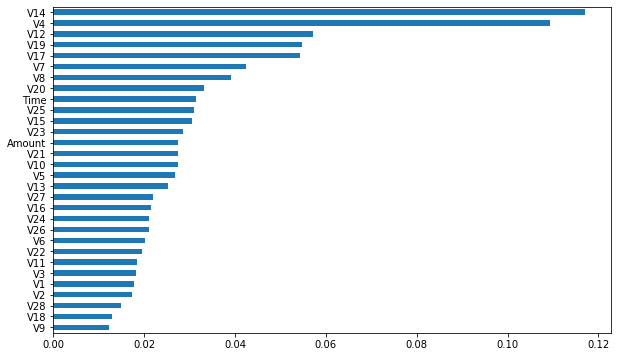

In [198]:
# モデルの特徴量重要度を確認する
plot_feature_importance(X_sampled, clf_eda3)

feature_importanceが変化しなくなってきたので、重要な特徴のしきい値選別がうまく言っている証。

## これまでのしきい値設定を逆に
- over sampling には SMOTEENN を利用してみる
- データ数を多くするためにdown_sampling量を調整する

In [411]:
# これまでのしきい値設定を逆にしてみる
indicies = \
    (X_train_b['V17'] < -2) | (X_train_b['V17'] > 5) | (X_train_b['V12'] < -5) | \
    (X_train_b['V14'] < -3) | (X_train_b['V10'] < -2) | (X_train_b['V4'] > 4)

X_train_prep = X_train_b[indicies]
y_train_prep = y_train_b[indicies]

X_train_prep.shape

(6273, 30)

In [412]:
# True
y_train_prep.value_counts()

False    5990
True      283
Name: Class, dtype: int64

In [413]:
over_sample_params = {
    0: y_train_prep.value_counts()[0], # 値はそのまま
    1: y_train_prep.value_counts()[0] // 2 # 2:1にするため
}

sampler = SMOTEENN(sampling_strategy=over_sample_params, random_state=98)
X_sampled, y_sampled = sampler.fit_sample(X_train_prep, y_train_prep)

# それぞれのデータ数を確認
print('Result over sampling')
print(X_sampled.shape)
print(y_sampled.value_counts())

Result over sampling
(5713, 30)
False    4107
True     1606
Name: Class, dtype: int64


In [420]:
# 学習
clf_final = RandomForestClassifier()
tic = time.time()
clf_final.fit(X_sampled, y_sampled)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 1.7150545120239258s


In [421]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf_final, X_sampled, y_sampled, X_test, y_test)

In [422]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      4107
        True       1.00      1.00      1.00      1606

    accuracy                           1.00      5713
   macro avg       1.00      1.00      1.00      5713
weighted avg       1.00      1.00      1.00      5713

学習データ：混同行列
 [[4107    0]
 [   0 1606]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.87      0.86      0.87       142

    accuracy                           1.00     85118
   macro avg       0.94      0.93      0.93     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：混同行列
 [[84958    18]
 [   20   122]]


In [417]:
print('\nテストデータ：ベースモデル予測結果\n', test_cr_base)
print('テストデータ：ベースモデル混同行列\n', test_matrix_base)


テストデータ：ベースモデル予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.93      0.84      0.88       142

    accuracy                           1.00     85118
   macro avg       0.96      0.92      0.94     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：ベースモデル混同行列
 [[84967     9]
 [   23   119]]


少しだけ異常データも当てられるようになった(その分正常を10件外している)

### クロスバリデーションで汎化性能を確認する

In [418]:
scores = cross_val_score(clf, X_test, y_test, scoring='f1_macro', cv=5)
print("Base Model Score: {} ".format(scores))
print("Base Model Mean Score: {}".format(np.mean(scores)))

Base Model Score: [0.87235783 0.9481876  0.90726032 0.94435619 0.89568627] 
Base Model Mean Score: 0.9135696407907243


In [419]:
scores = cross_val_score(clf_final, X_test, y_test, scoring='f1_macro', cv=5)
print("Preprocessed Model Score : {} ".format(scores))
print("Preprocessed Model Mean Score: {}".format(np.mean(scores)))

Preprocessed Model Score : [0.87235783 0.93626067 0.87716729 0.91988234 0.89568627] 
Preprocessed Model Mean Score: 0.9002708782381811


## まとめ

データを選別したり、サンプリングを組み合わせることで、少しだけ異常なデータを当てられるようになった(4件)

サンプリング手法をもっと高度なものにしたり、更にEDAを深めることでより分類に寄与する特徴が抽出できることで、データバランスが偏ったものでもモデル性能が向上できる。

## appendix: 特徴量選択をした結果と比較する

In [341]:
from sklearn.feature_selection import RFE

rfe_selector = RFE(clf_final)
rfe_selector.fit(X_sampled, y_sampled)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [342]:
# 選別の結果を適用してみる
mask = rfe.get_support()
print('before rfe selection')
print(X_sampled.columns)
print('after rfe selection')
print(X_sampled.columns[mask])

before rfe selection
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
after rfe selection
Index(['V1', 'V3', 'V4', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16',
       'V17', 'V18', 'V21', 'Amount'],
      dtype='object')


In [343]:
# 選別した特徴量で学習
clf_final = RandomForestClassifier()
tic = time.time()
clf_final.fit(X_sampled.loc[:, mask], y_sampled)
toc = time.time()
print('Execution Time: {}s'.format(toc - tic))

Execution Time: 1.5312488079071045s


In [344]:
train_cr, train_matrix, test_cr, test_matrix = \
    get_classification_result(clf_final, X_sampled.loc[:, mask], y_sampled, X_test.loc[:, mask], y_test)

In [345]:
print('学習データ：予測結果\n', train_cr)
print('学習データ：混同行列\n', train_matrix)
print('\nテストデータ：予測結果\n', test_cr)
print('テストデータ：混同行列\n', test_matrix)

学習データ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      3565
        True       1.00      1.00      1.00      4207

    accuracy                           1.00      7772
   macro avg       1.00      1.00      1.00      7772
weighted avg       1.00      1.00      1.00      7772

学習データ：混同行列
 [[3565    0]
 [   0 4207]]

テストデータ：予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.86      0.87      0.86       142

    accuracy                           1.00     85118
   macro avg       0.93      0.93      0.93     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：混同行列
 [[84956    20]
 [   19   123]]


In [231]:
print('\nテストデータ：ベースモデル予測結果\n', test_cr_base)
print('テストデータ：ベースモデル混同行列\n', test_matrix_base)


テストデータ：ベースモデル予測結果
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     84976
        True       0.93      0.84      0.88       142

    accuracy                           1.00     85118
   macro avg       0.96      0.92      0.94     85118
weighted avg       1.00      1.00      1.00     85118

テストデータ：ベースモデル混同行列
 [[84967     9]
 [   23   119]]


## appendix: 当てられなかったデータについて見てみる

In [496]:
df_check = X_test.copy()
df_check['Class'] = y_test
df_check['Predict'] = clf_final.predict(X_test)

In [499]:
# 予測に失敗したデータだけで構成
df_miss = df_check[df_check['Class'] != df_check['Predict']]

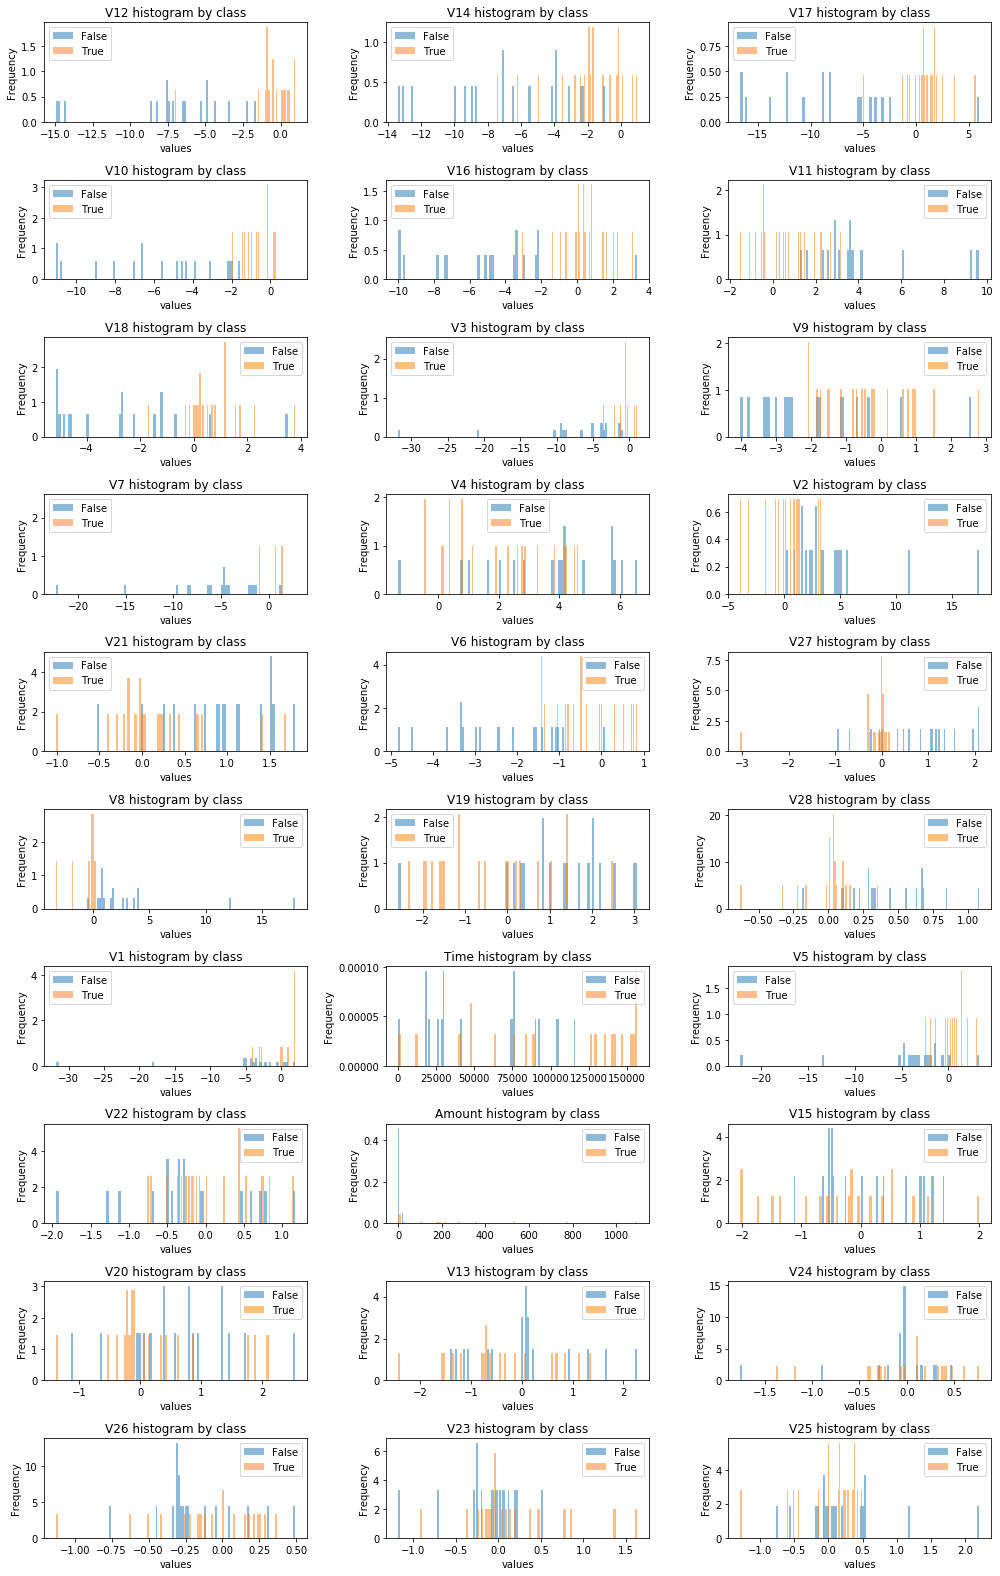

In [543]:
# 上位特徴量について確認
columns = df_miss.columns.tolist()
fe = clf_final.feature_importances_
series = pd.Series(dict(zip(columns, fe)))
fi_col_list = series.sort_values(ascending=False)
n = len(fi_col_list)

fig, ax = plt.subplots(figsize=(14, 22), nrows=n//3, ncols=3)
for i, col_name in enumerate(fi_col_list.index.tolist()):
    idx = i // 3
    col = i % 3
    # density オプションは大きさを正規化したもの (正規化しない場合は正例が多すぎるため、負例の分布が見られなくなってしまう)
    df_miss.groupby('Class')[col_name].plot(kind='hist', bins=100, ax=ax[idx, col], alpha=0.5, density=True)
    ax[idx, col].set_title('{} histogram by class'.format(col_name))
    ax[idx, col].set_xlabel('values')
    ax[idx, col].legend()
plt.tight_layout()

当てられないデータについてはそもそも重要特徴量で分岐させてしまうと間違えてしまう特徴量。

## appendix: 特徴量とクラスで箱ひげ図を作成して外れ値を見る例

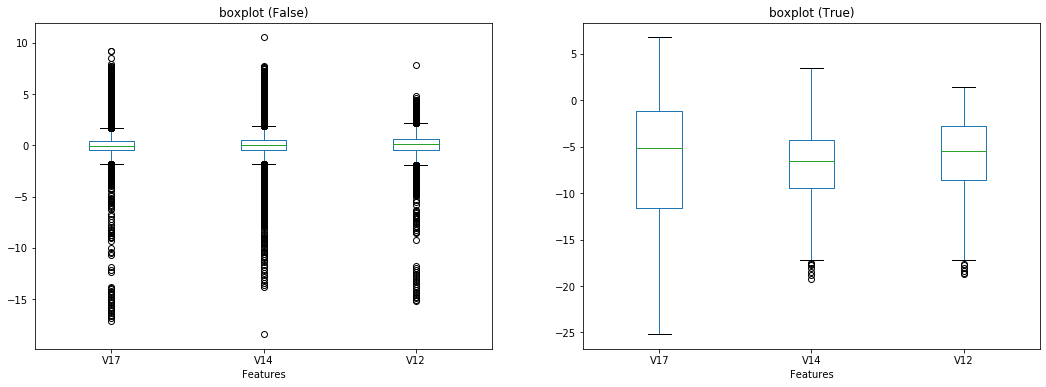

In [75]:
# 箱ひげ図を使ってクラスとV17,14,12の3つを軸に外れ値を確認する
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)

for class_value in range(2):
    df[df['Class'] == class_value][['V17', 'V14', 'V12']].plot(kind='box', ax=ax[class_value])
    ax[class_value].set_title('boxplot ({})'.format(bool(class_value)))
    ax[class_value].set_xlabel('Features')

## appendix: ランダムフォレストのtree可視化

In [178]:
# 試しに木の一つを視覚化する
import pydotplus as pdp
from sklearn import tree
from sklearn.externals.six import StringIO

dot_data = StringIO()
tree.export_graphviz(
    clf.estimators_[0],
    out_file=dot_data,
    filled=True,
    feature_names=X_train_prep.columns,
    class_names=clf.classes_.astype(str)
)

# tree.export_graphviz(clf.estimators_[0], # 決定木オブジェクトを一つ指定する
#                     out_file=dot_data, # ファイルは介さずにGraphvizにdot言語データを渡すのでNone
#                     filled=True, # Trueにすると、分岐の際にどちらのノードに多く分類されたのか色で示してくれる
#                     feature_names=X_train_prep.columns, # これを指定しないとチャート上で特徴量の名前が表示されない
#                     class_names=clf.classes_
#                     )
graph = pdp.graph_from_dot_data(dot_data.getvalue())

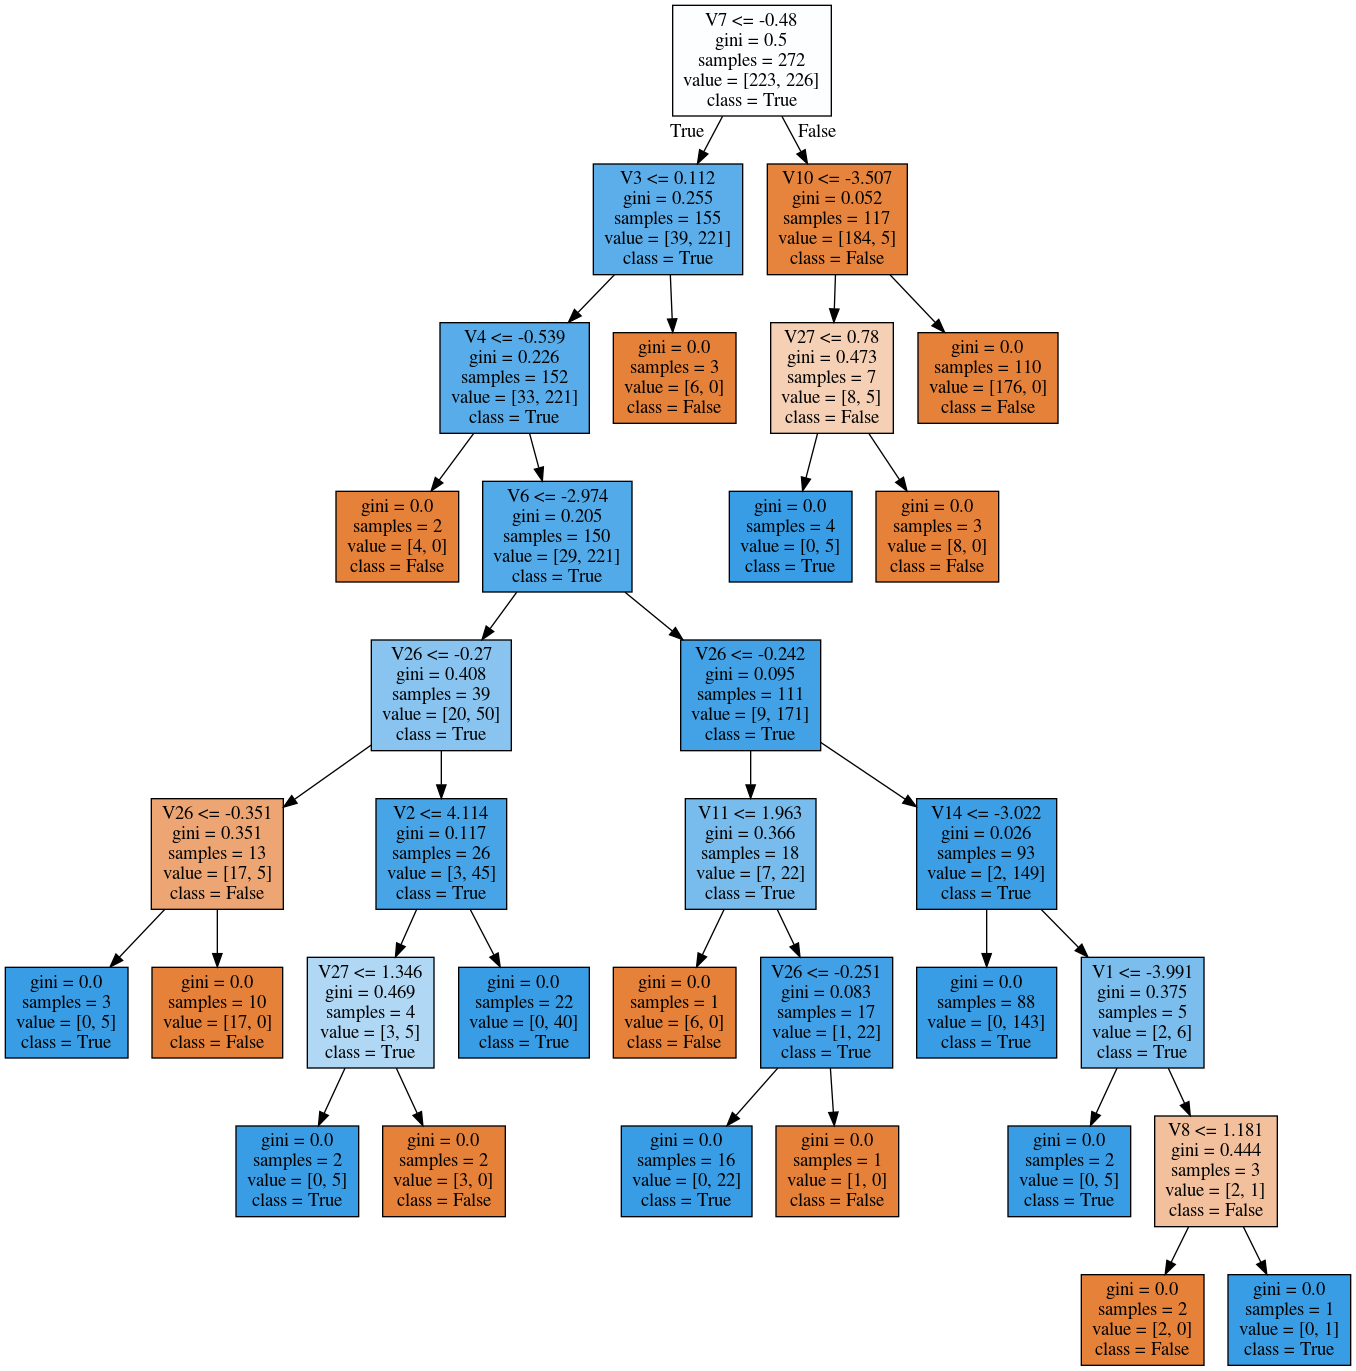

In [134]:
from IPython.display import Image
Image(graph.create_png())